#  **Multivariate Time Series Forecasting Problem** 

- #### Supervised
- #### Regression


#### ***The motor in the dataset is a Permanent Magnet Synchronous Motor (PMSM), which is a type of AC electric motor. The use of d/q coordinates, the control strategy, and the presence of permanent magnets all point to this conclusion.***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image ,SVG
import dataframe_image as dfi
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df =pd.read_csv("temperature_data (1).csv")
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


# Feature Categorization

## 1. Electrical Features
These are related to the electrical behavior of the motor:

### Voltage Components:
- **`u_d`**: Direct-axis voltage.
- **`u_q`**: Quadrature-axis voltage.

### Current Components:
- **`i_d`**: Direct-axis current.
- **`i_q`**: Quadrature-axis current.

---

## 2. Mechanical Features
These are related to the mechanical behavior of the motor:

### Speed and Torque:
- **`motor_speed`**: Rotational speed of the motor.
- **`torque`**: Torque produced by the motor.

### Temperature Features:
- **`pm`**: Permanent magnet temperature (rotor temperature).
- **`stator_yoke`**: Stator yoke temperature.
- **`stator_tooth`**: Stator tooth temperature.
- **`stator_winding`**: Stator winding temperature.

---

## 3. Environmental Features
These are related to the external environment:

- **`ambient`**: Ambient temperature.
- **`coolant`**: Coolant temperature.

In [3]:
df.dtypes

ambient           float64
coolant           float64
u_d               float64
u_q               float64
motor_speed       float64
torque            float64
i_d               float64
i_q               float64
pm                float64
stator_yoke       float64
stator_tooth      float64
stator_winding    float64
profile_id          int64
dtype: object

# EDA

#### The plots below show that all measurement sessions range from 20 minutes to around 6 hours. The two short session ids "46" and "47" might be not very representative as temperatures inside electric motors need time to vary.

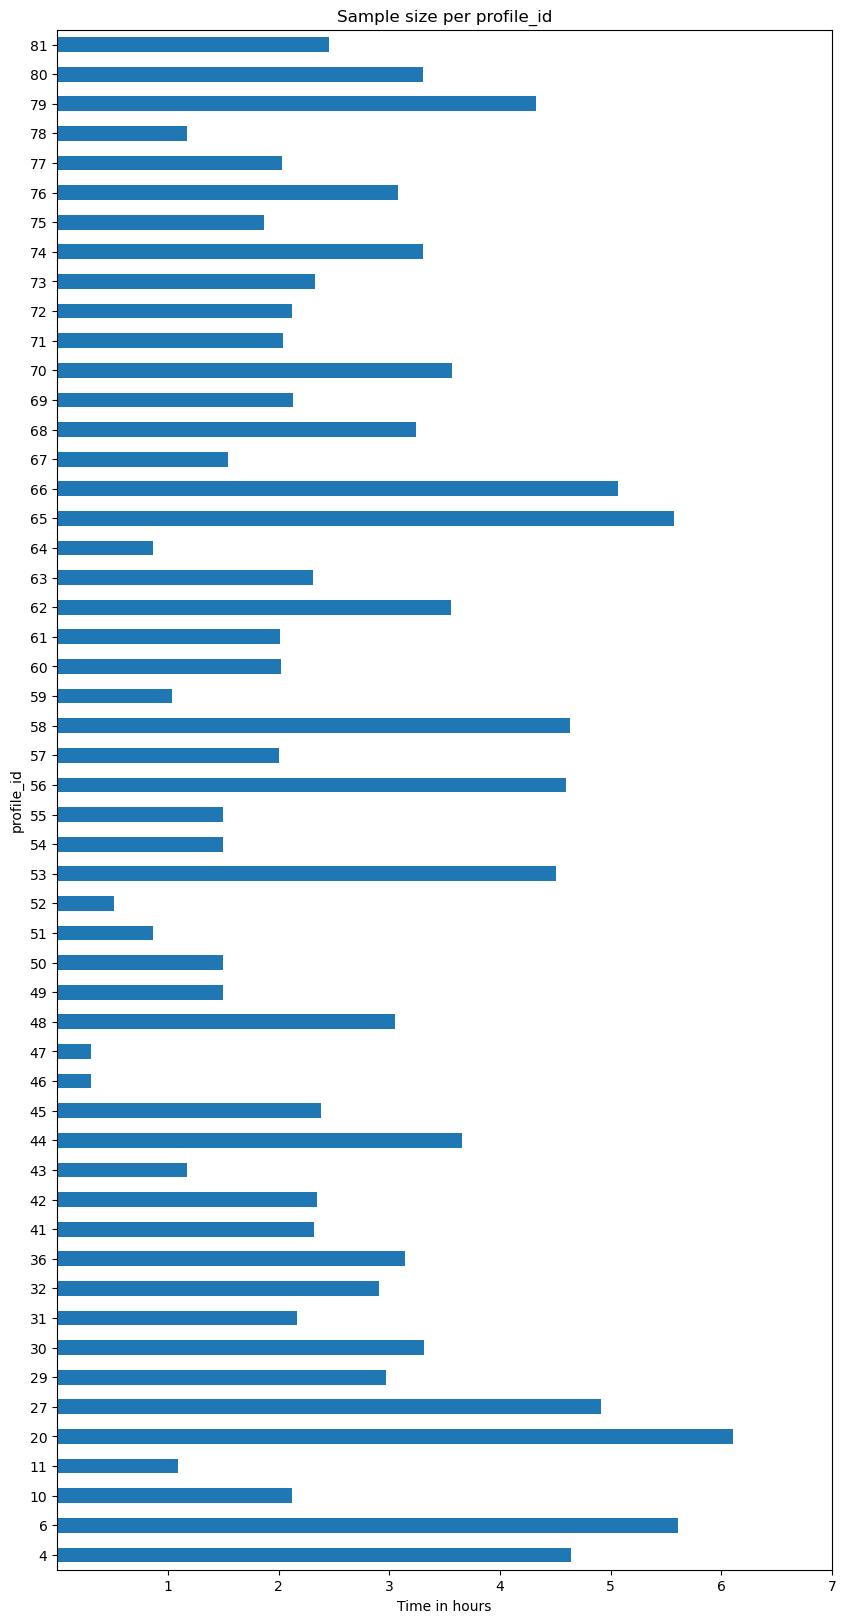

In [4]:
# Group by profile_id and count the number of samples
p_counts = df.groupby('profile_id')['ambient'].agg('count')  # Replace 'ambient' with any column

# Plot the sample sizes
ax = p_counts.plot.barh(figsize=(10, 20), title='Sample size per profile_id')

# Convert sample counts to time (if sampling rate is known)
sampling_rate = 2  # Replace with your dataset's sampling rate (in Hz)
_ = ax.set_xticks(sampling_rate * 3600 * np.arange(1, 8))  # Convert to hours
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

plt.show()

### *What Are These Sessions?*

1. Each profile_id corresponds to a unique measurement session where the motor was operated under specific conditions.

2. During each session, temperatures, voltages, currents, speed, torque was recorded at a sampling rate of 2 Hz (every 0.5 seconds).

***The two very short sessions (profile_id 46 and 47) might be Outliers so we wont be using it in our dataset***


### Time Series Plots

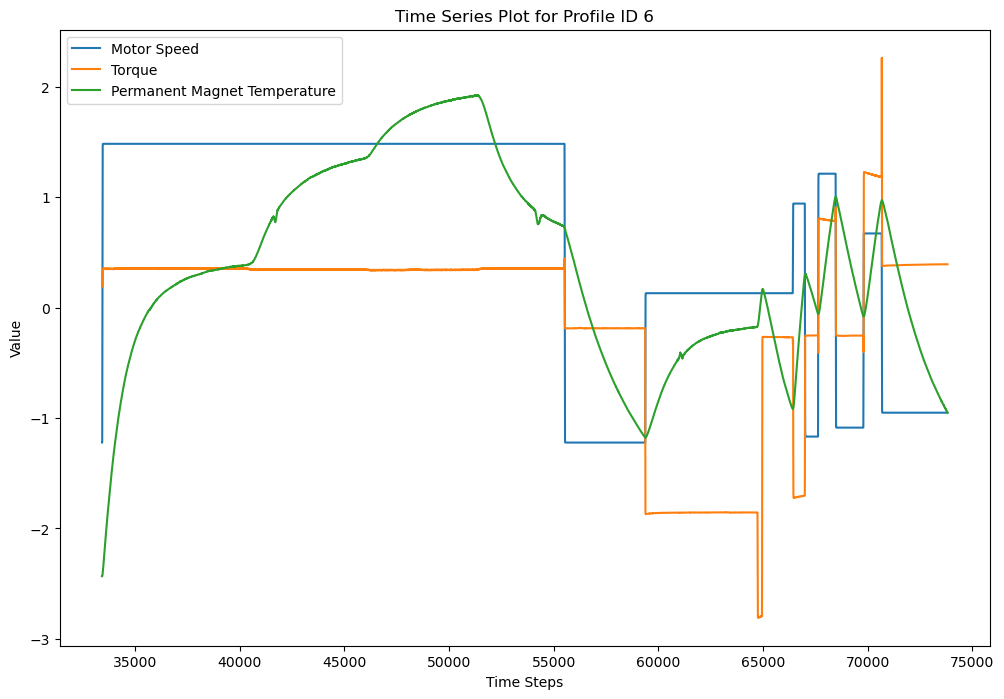

In [5]:
# Filter data for a specific profile_id
profile_data = df[df['profile_id'] == 6]

# Plot time series for selected features
plt.figure(figsize=(12, 8))
plt.plot(profile_data['motor_speed'], label='Motor Speed')
plt.plot(profile_data['torque'], label='Torque')
plt.plot(profile_data['pm'], label='Permanent Magnet Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Time Series Plot for Profile ID 6')
plt.legend()
plt.show()

#### The dataset is sampled at 2 Hz, meaning data is recorded every 0.5 seconds.

#### Each time step represents 0.5 seconds of elapsed time.

Range on the X-Axis:

The x-axis ranges from 35,000 to 75,000 time steps.

This corresponds to a total duration of:

Total Duration
=
(
75
,
000
−
35
,
000
)
 time steps/
2
 Hz
=
20
,
000
 seconds
≈
5.56
 hours
Total Duration= 
2 Hz
(75,000−35,000) time steps
​
 =20,000 seconds≈5.56 hours

### Session Length Analysis


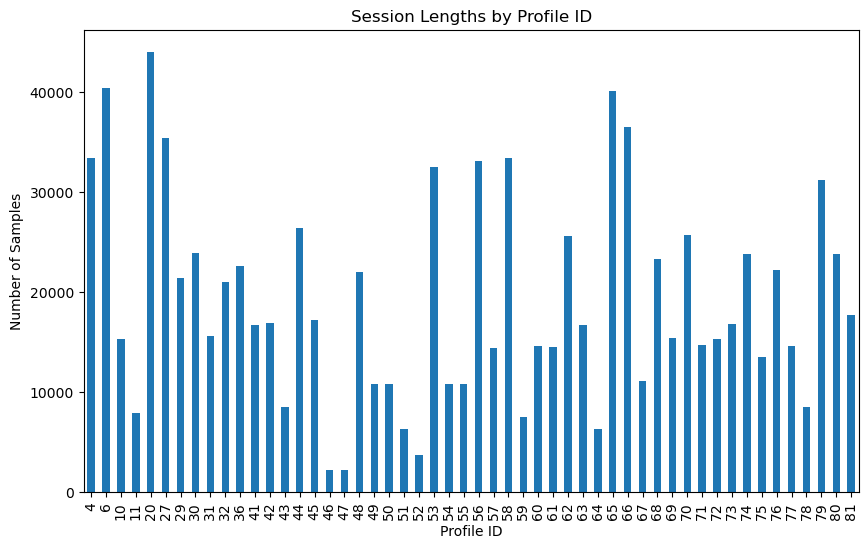

In [6]:
# Group by profile_id and count the number of samples
p_counts = df.groupby('profile_id').size()

# Plot session lengths
plt.figure(figsize=(10, 6))
p_counts.plot(kind='bar')
plt.xlabel('Profile ID')
plt.ylabel('Number of Samples')
plt.title('Session Lengths by Profile ID')
plt.show()

### Rolling Averages

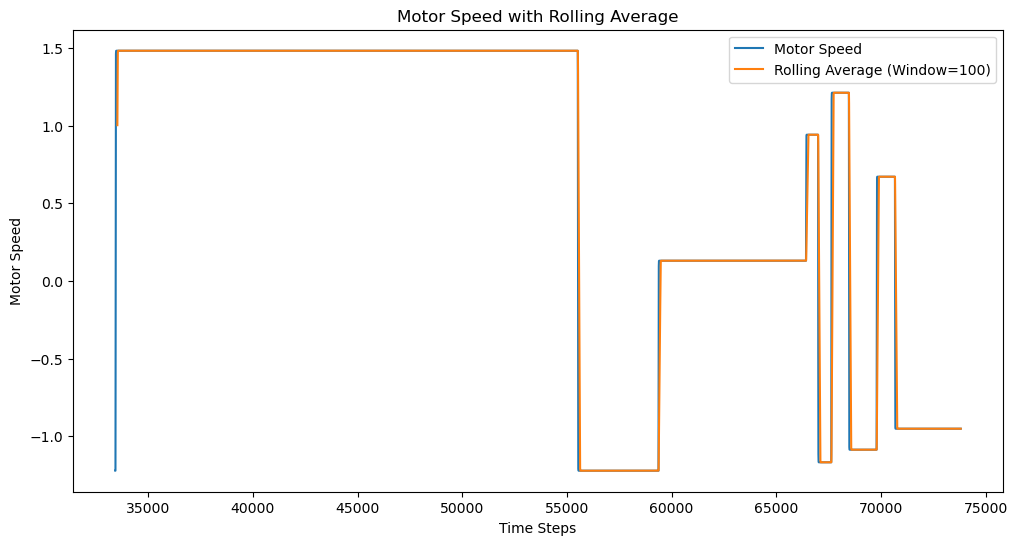

In [7]:
# Compute rolling average for motor_speed
rolling_avg = profile_data['motor_speed'].rolling(window=100).mean()

# Plot rolling average
plt.figure(figsize=(12, 6))
plt.plot(profile_data['motor_speed'], label='Motor Speed')
plt.plot(rolling_avg, label='Rolling Average (Window=100)')
plt.xlabel('Time Steps')
plt.ylabel('Motor Speed')
plt.title('Motor Speed with Rolling Average')
plt.legend()
plt.show()

### Trend:

##### - The rolling average (orange line) shows the overall trend in motor speed over time.
##### - If it slopes upward, motor speed is increasing; if it slopes downward, motor speed is decreasing.

### Noise:

##### - The original data (blue line) shows short-term fluctuations around the rolling average, which could be due to random noise or rapid changes in operating conditions.

### Stability:

##### - If the rolling average is relatively flat, the motor speed is stable. If it fluctuates, the motor speed is changing over time.

### 100 time steps correspond to 50 seconds of real time.

### The rolling average window of 100 steps means the average is calculated over the past 50 seconds of data.

In [8]:
df3 = df.copy()

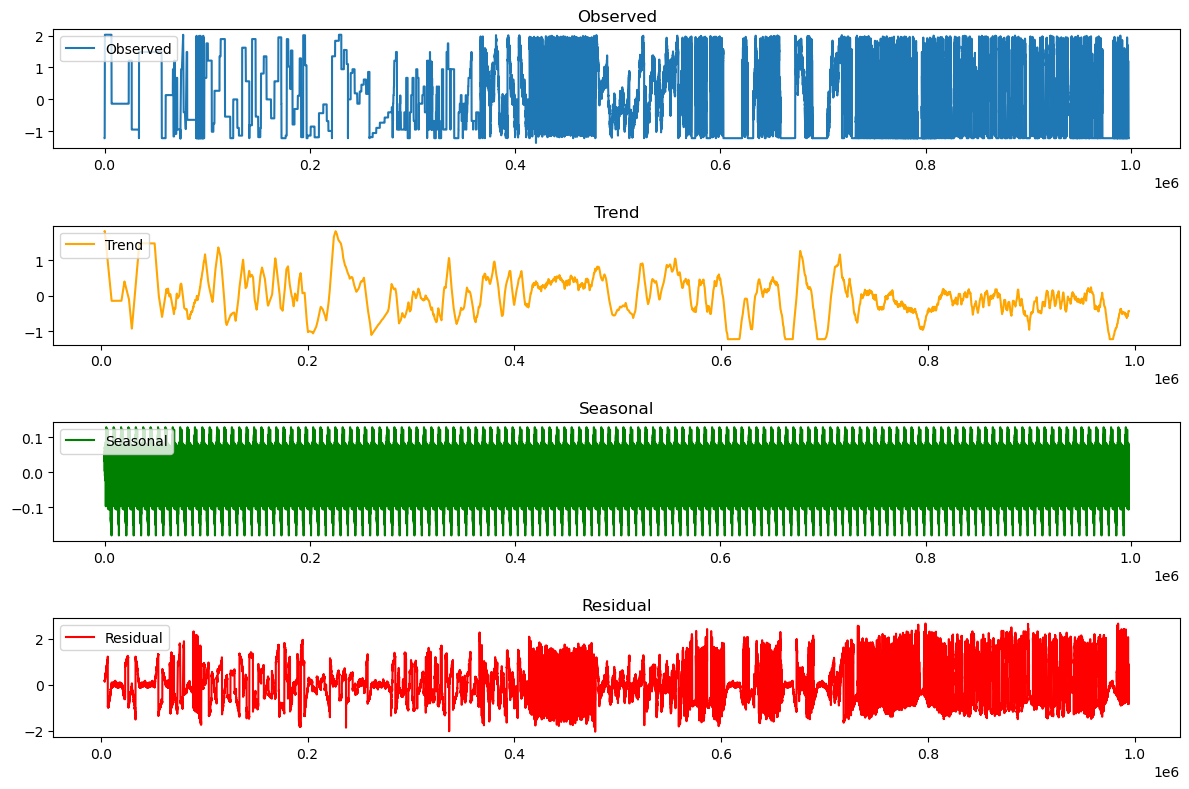

In [9]:
# Perform seasonal decomposition on 'motor_speed' in df3
decomposition = seasonal_decompose(df3['motor_speed'], model='additive', period=2*3600)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Observed
plt.subplot(4, 1, 1)
plt.plot(df3['motor_speed'], label='Observed')
plt.legend(loc='upper left')
plt.title('Observed')

# Trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

# Residual
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()

### Trend:

The trend is relatively stable, indicating that the variable (e.g., motor_speed) doesn't exhibit significant long-term changes over the observed period.

### Seasonality:

The seasonal component shows weak periodic patterns, suggesting that there is some repeating behavior in the data, but it is not very strong.

### Residual:

The residual component is small and random, indicating that the trend and seasonal components explain most of the variability in the data.### 

### Line Plots for Temperature Features

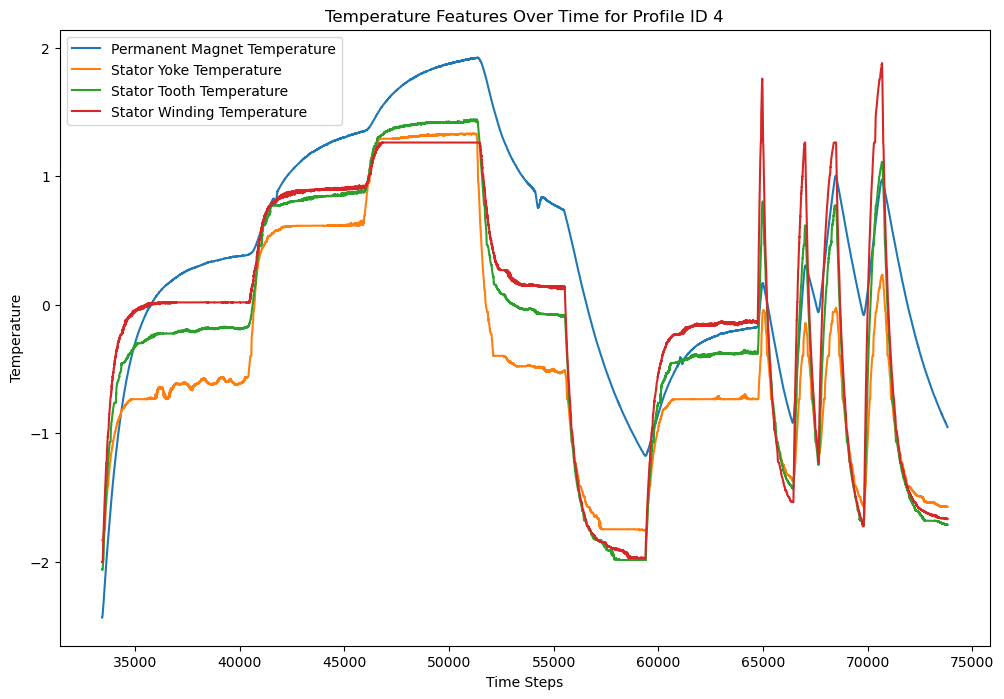

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(profile_data['pm'], label='Permanent Magnet Temperature')
plt.plot(profile_data['stator_yoke'], label='Stator Yoke Temperature')
plt.plot(profile_data['stator_tooth'], label='Stator Tooth Temperature')
plt.plot(profile_data['stator_winding'], label='Stator Winding Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('Temperature Features Over Time for Profile ID 4')
plt.legend()

In [11]:
df

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725,72
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013416,0.834438,0.494279,72
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666,72
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581,72


#### Drop the 'profile_id' column

In [12]:
df = df.drop(columns=['profile_id'])

#### Check Null Values

In [13]:
df.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
dtype: int64

#### Check Duplicates

In [14]:
# Check for duplicate rows
duplicates = df[df.duplicated()]

print("Duplicate Rows:")
print(duplicates)

Duplicate Rows:
Empty DataFrame
Columns: [ambient, coolant, u_d, u_q, motor_speed, torque, i_d, i_q, pm, stator_yoke, stator_tooth, stator_winding]
Index: []


#### Data Types and Structure

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ambient         998070 non-null  float64
 1   coolant         998070 non-null  float64
 2   u_d             998070 non-null  float64
 3   u_q             998070 non-null  float64
 4   motor_speed     998070 non-null  float64
 5   torque          998070 non-null  float64
 6   i_d             998070 non-null  float64
 7   i_q             998070 non-null  float64
 8   pm              998070 non-null  float64
 9   stator_yoke     998070 non-null  float64
 10  stator_tooth    998070 non-null  float64
 11  stator_winding  998070 non-null  float64
dtypes: float64(12)
memory usage: 91.4 MB


#### Descriptive Statistics

In [16]:
df.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781


#### Distribution of Variables / Visualization

##### Histograms for numerical columns

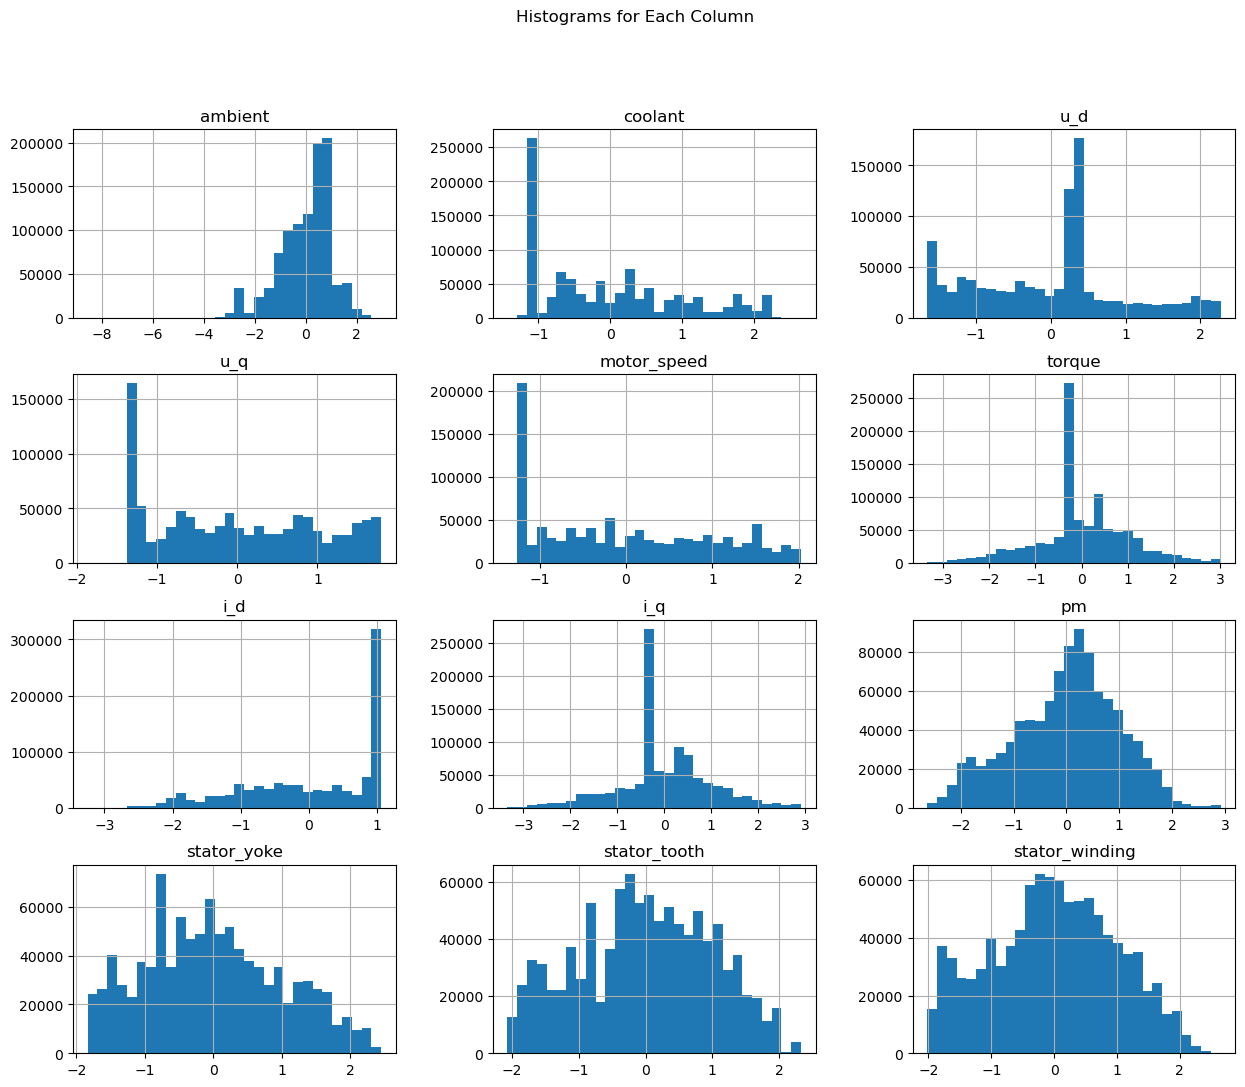

In [17]:
df.hist(bins=30, figsize=(15, 12))
plt.suptitle('Histograms for Each Column')
plt.show()

#### Check Skewness

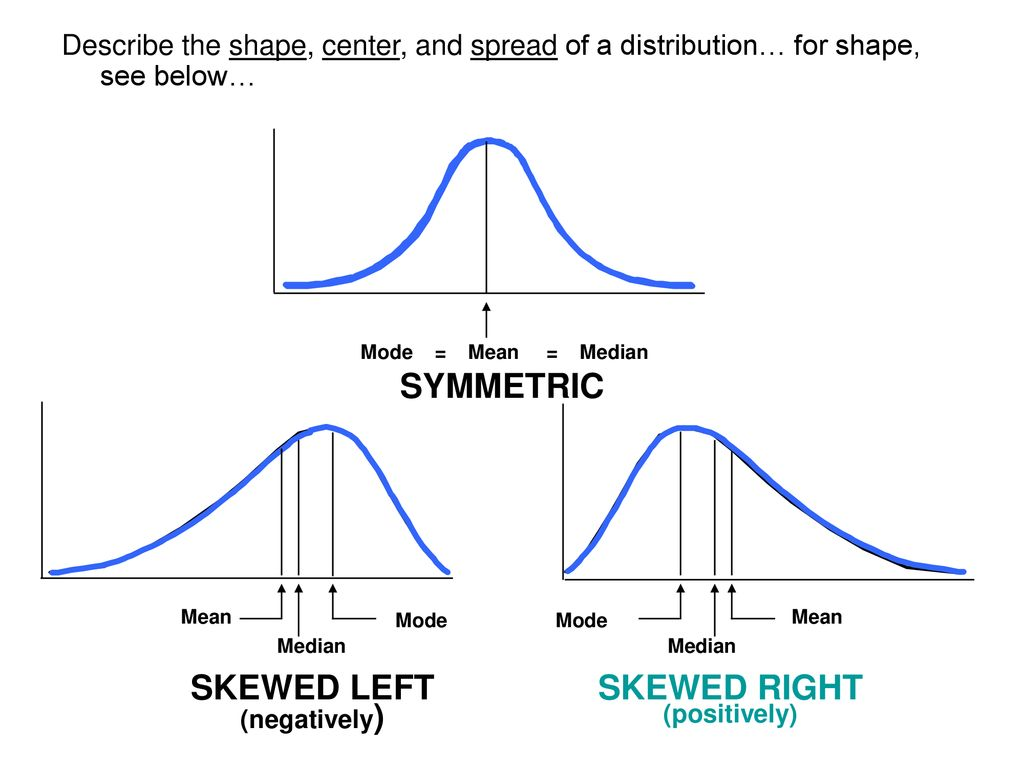

In [18]:
Image(filename=r"D:\ELectric Motor\Skewed.jpg", width=700, height=200)

In [19]:
skewness = df.skew()
print("Skewness of each column:")
print(skewness)

Skewness of each column:
ambient          -0.848914
coolant           0.628247
u_d               0.194644
u_q               0.199885
motor_speed       0.333305
torque           -0.042660
i_d              -0.622578
i_q              -0.075705
pm               -0.232903
stator_yoke       0.257297
stator_tooth     -0.061533
stator_winding   -0.028055
dtype: float64


### *Negative Skewness (Left-Skewed):*

##### ambient (-0.848914): Moderately left-skewed.

##### i_d (-0.622578): Slightly left-skewed.

##### torque (-0.042660): Nearly symmetric (very slight left skew).

##### i_q (-0.075705): Nearly symmetric (very slight left skew).

##### pm (-0.232903): Slightly left-skewed.

##### stator_tooth (-0.061533): Nearly symmetric (very slight left skew).

##### stator_winding (-0.028055): Nearly symmetric (very slight left skew).

### *Positive Skewness (Right-Skewed):*

##### coolant (0.628247): Moderately right-skewed.

##### u_d (0.194644): Slightly right-skewed.

##### u_q (0.199885): Slightly right-skewed.

##### motor_speed (0.333305): Slightly right-skewed.

##### stator_yoke (0.257297): Slightly right-skewed.


### When to Apply Transformations?

##### Left-Skewed Data (Negative Skewness):

Apply transformations like reflection + log or reflection + square root.

##### Right-Skewed Data (Positive Skewness):

Apply transformations like log, square root, or Box-Cox.

##### Nearly Symmetric Data (Skewness Close to 0):

No transformation is needed, but monitor the data during analysis.



#### Summary of Transformations:
##### Apply Transformations:

ambient: Reflection + log.

coolant: Log or square root.

i_d: Reflection + log.

##### Optional Transformations:

u_d, u_q, motor_speed, stator_yoke: Square root (if you want to reduce skewness further).

##### No Transformations Needed:

torque, i_q, pm, stator_tooth, stator_winding.

### I have not applied Transformation because The Skewness is Mild & Some machine learning models (e.g., decision trees, random forests, gradient boosting) are less sensitive to skewed data and can handle it without transformations.

 # Check For Outliers

#### What to do with outliers?

We have three basic options for outliers:

#### 1. Ignore them — just include them in the data and all analyses

#### 2. Remove them completely from the DataFrame (TRIMMING)

#### 3. Replace them with non-outlier values (CAPPING)

#### When to Use Z-Score for Outliers

Use Z-scores when your data is approximately normally distributed.

For non-normal distributions, consider other methods like the IQR (Interquartile Range) method.

In [20]:
# Calculate Z-scores
from scipy.stats import zscore
z_scores = df.apply(zscore)

# Identify outliers (absolute Z-score > 3)
outliers = (z_scores.abs() > 3)

# Count outliers in each column
outlier_counts = outliers.sum()

print("Outliers in each column:")
print(outlier_counts)

# Around 11,000 Outliers detected using Z -score

Outliers in each column:
ambient           2760
coolant              0
u_d                  0
u_q                  0
motor_speed          0
torque            5119
i_d                543
i_q               2571
pm                   0
stator_yoke          0
stator_tooth         0
stator_winding       0
dtype: int64


### **Types of Outliers**

| **Type of Outlier**       | **Description**                                                                 | **Example**                                                                 |
|---------------------------|---------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Point Outliers**         | Individual data points that are significantly different from the rest of the data. | A single unusually high or low value in a dataset (e.g., a temperature reading of 1000°C). |
| **Contextual Outliers**    | Data points that are outliers in a specific context but not necessarily in the entire dataset. | A temperature of 30°C might be normal in summer but an outlier in winter.   |
| **Collective Outliers**    | A group of data points that are collectively unusual, even if individually they are not outliers. | A sudden spike in website traffic due to a viral event.                     |
| **Global Outliers**        | Data points that are outliers relative to the entire dataset.                   | A person who is 8 feet tall in a dataset of human heights.                  |
| **Local Outliers**         | Data points that are outliers within a specific subset of the data.             | A student scoring 100% in a class where most students score below 50%.      |

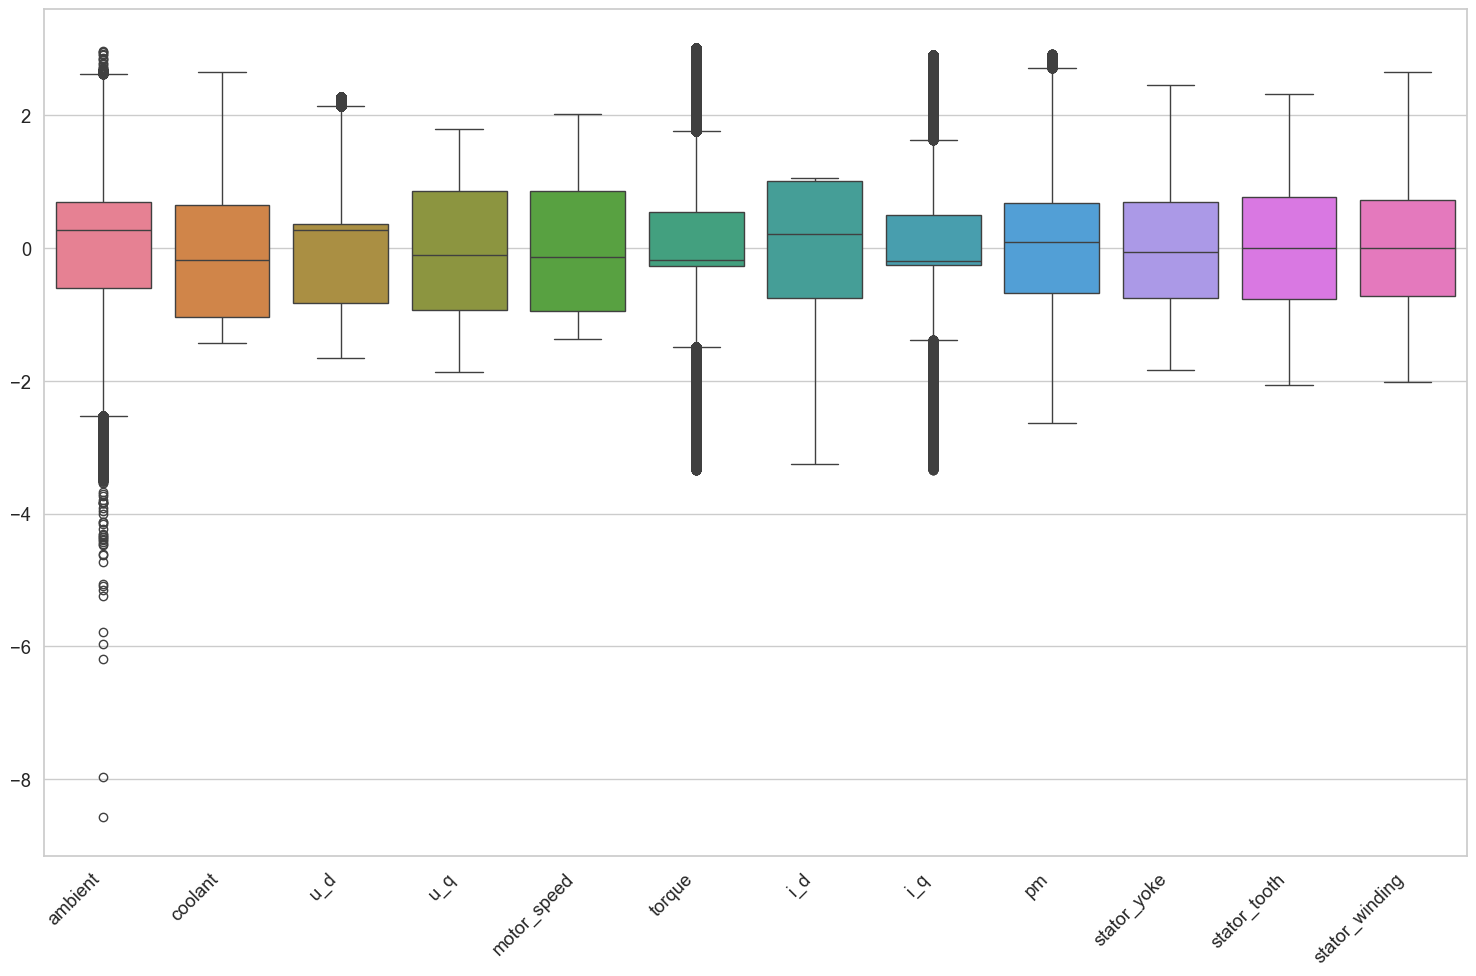

In [21]:
# Boxplots
sns.set(style="whitegrid", font_scale=1.2)  # Increase font scale and use a clean style

# Create a box plot for all l columns
plt.figure(figsize=(15, 10))  # Adjust figure size
sns.boxplot(data=df)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


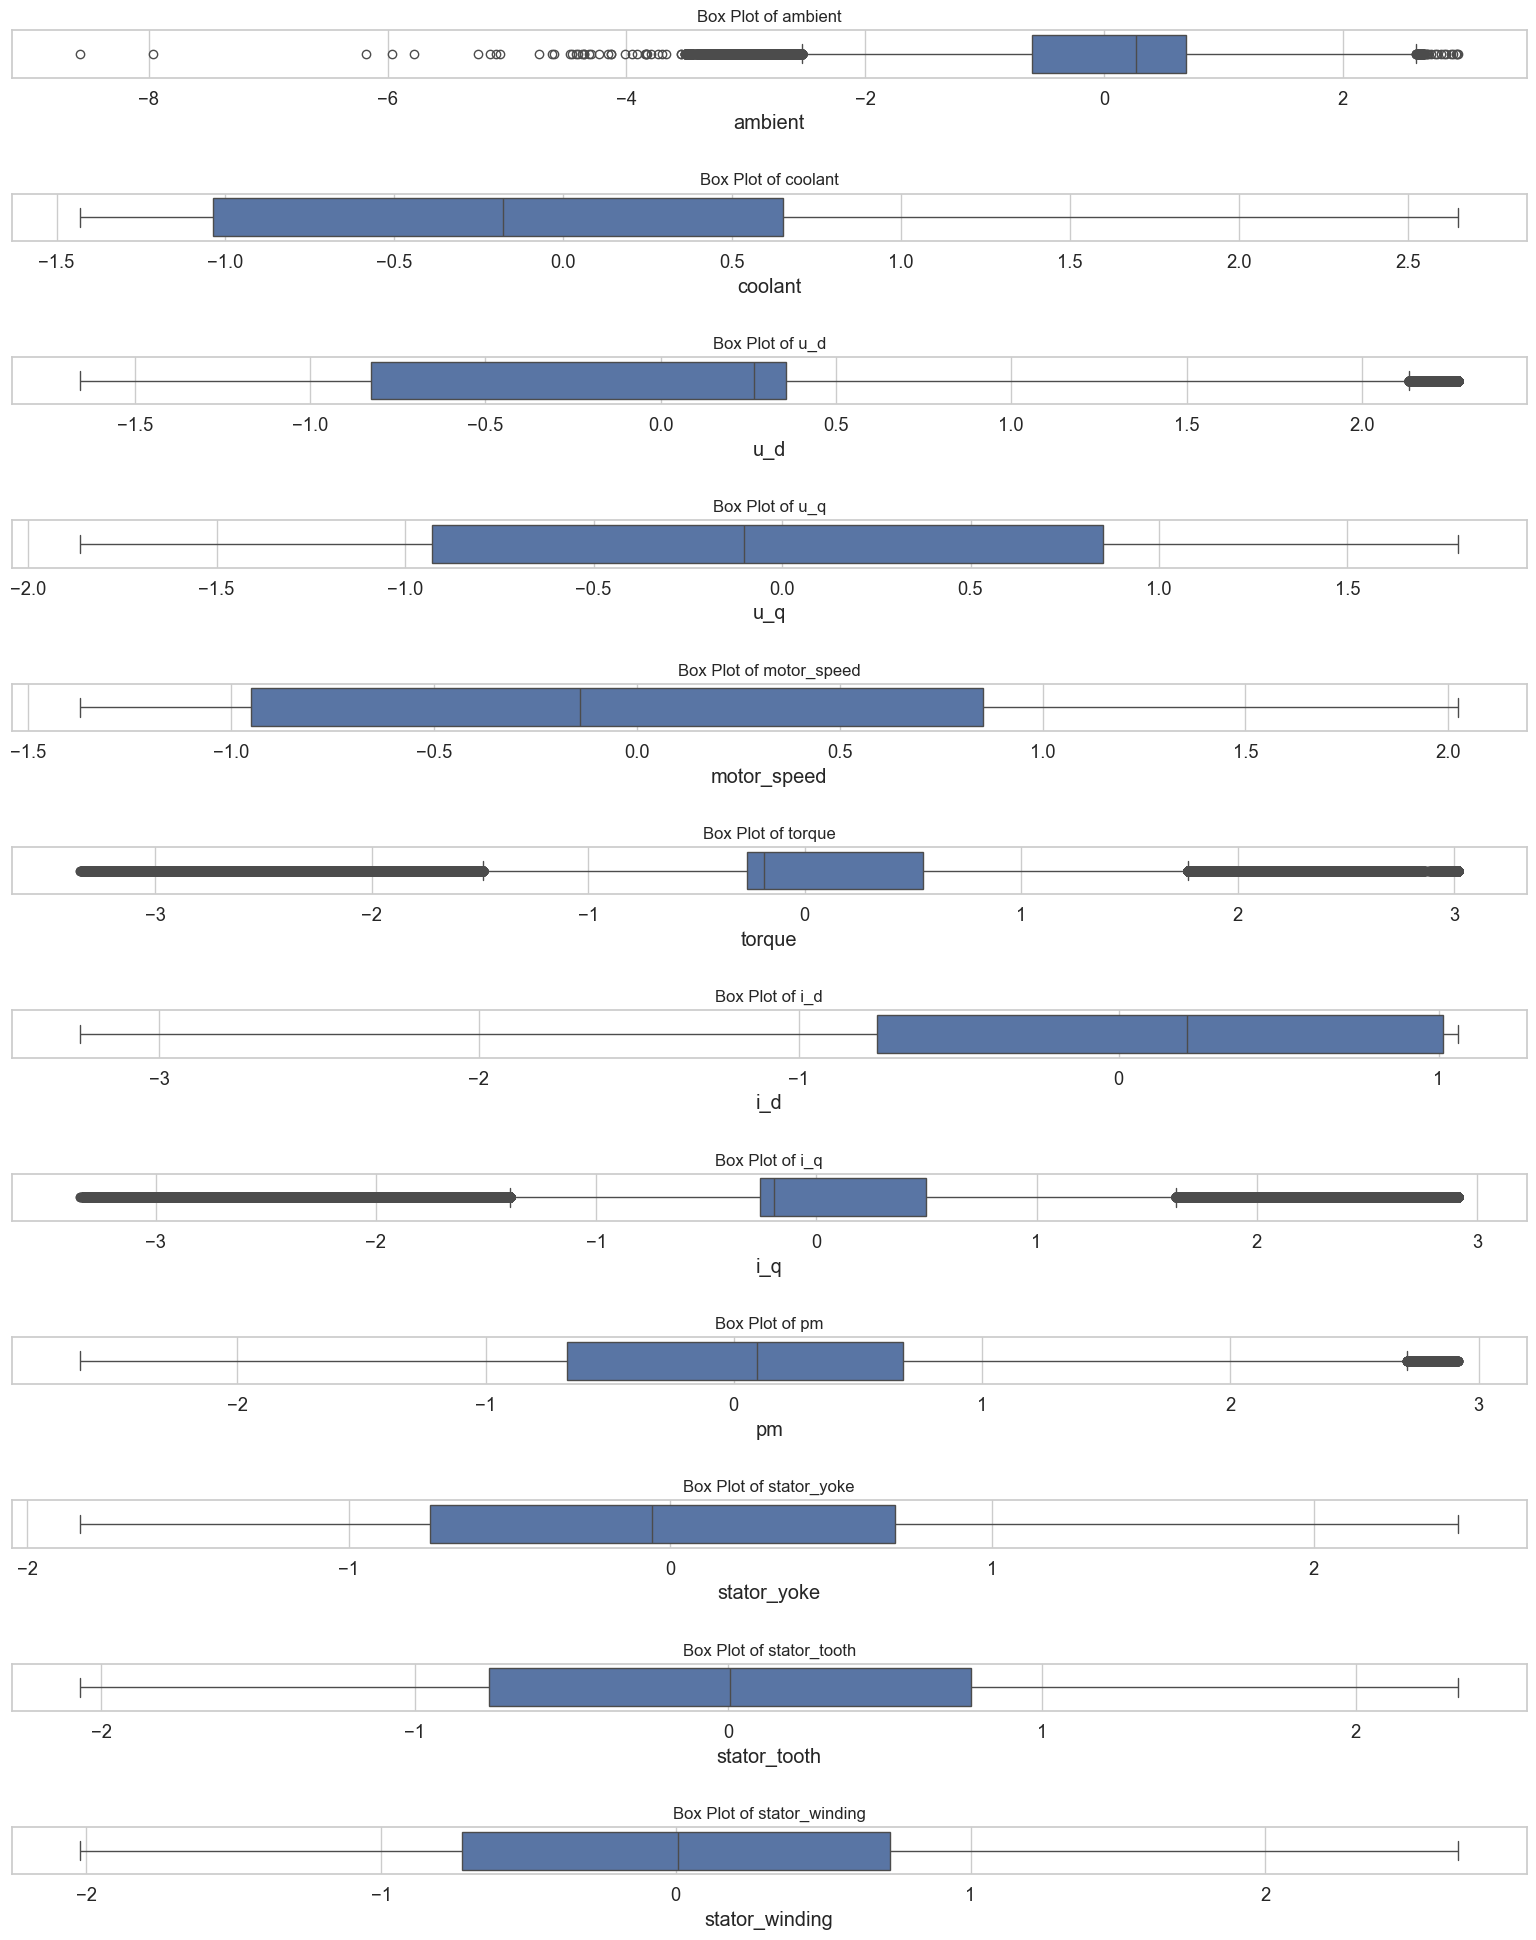

In [22]:
# Create subplots
fig, axes = plt.subplots(12, 1, figsize=(16, 20), sharex=False, sharey=False)

# Plot box plots for each column
sns.boxplot(x='ambient', data=df, ax=axes[0])
sns.boxplot(x='coolant', data=df, ax=axes[1])
sns.boxplot(x='u_d', data=df, ax=axes[2])
sns.boxplot(x='u_q', data=df, ax=axes[3])
sns.boxplot(x='motor_speed', data=df, ax=axes[4])
sns.boxplot(x='torque', data=df, ax=axes[5])
sns.boxplot(x='i_d', data=df, ax=axes[6])
sns.boxplot(x='i_q', data=df, ax=axes[7])
sns.boxplot(x='pm', data=df, ax=axes[8])
sns.boxplot(x='stator_yoke', data=df, ax=axes[9])
sns.boxplot(x='stator_tooth', data=df, ax=axes[10])
sns.boxplot(x='stator_winding', data=df, ax=axes[11])

# Add titles to subplots
axes[0].set_title('Box Plot of ambient', fontsize=12)
axes[1].set_title('Box Plot of coolant', fontsize=12)
axes[2].set_title('Box Plot of u_d', fontsize=12)
axes[3].set_title('Box Plot of u_q', fontsize=12)
axes[4].set_title('Box Plot of motor_speed', fontsize=12)
axes[5].set_title('Box Plot of torque', fontsize=12)
axes[6].set_title('Box Plot of i_d', fontsize=12)
axes[7].set_title('Box Plot of i_q', fontsize=12)
axes[8].set_title('Box Plot of pm', fontsize=12)
axes[9].set_title('Box Plot of stator_yoke', fontsize=12)
axes[10].set_title('Box Plot of stator_tooth', fontsize=12)
axes[11].set_title('Box Plot of stator_winding', fontsize=12)


# Adjust layout
plt.tight_layout(pad=2.0)
plt.show()

In [23]:
outlier = "Outlier.svg"
SVG(filename=outlier)

#### Why we will be using IQR and not Z-score?

| **Aspect**      | **Z-Score (Normal Data)**                                                                 | **IQR (Non-Normal Data)**                                                                 |
|------------------|------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Assumption**   | Assumes data is normally distributed.                                                    | No assumption about distribution. Non-parametric and works well for skewed or non-normal data. |
| **How it Works** | Measures how many standard deviations a data point is from the mean. Outliers are typically defined as Z-score > 3 or < -3. | IQR is the range between Q1 (25th percentile) and Q3 (75th percentile). Outliers are defined as data points below Q1 - 1.5×IQR or above Q3 + 1.5×IQR. |
| **Why it Works** | In a normal distribution, ~99.7% of data lies within ±3 standard deviations from the mean. | Based on percentiles, which are robust to skewness and extreme values. Focuses on the middle 50% of the data. |
| **Limitations**  | Misidentifies outliers if data is not normally distributed, as mean and standard deviation are influenced by skewness or extreme values. | For normally distributed data, IQR might be less precise than Z-score as it doesn't leverage the properties of the normal distribution. |

#### Removing Outliers using IQR with Trimming technique

#### Why Trimming?
With 998,070 rows and 12 columns, and around 11,000 outliers detected using the Z-score method, we have a relatively small proportion of outliers (about 1% of your data). Our dataset is large, and removing a small percentage of rows won’t significantly impact the analysis. 


In [24]:
# Create a copy of the DataFrame to avoid modifying the original
df1 = df.copy()

#### Trim Outliers from the ambient Column

In [25]:
# Calculate Q1, Q3, and IQR

Q1_amb = df1['ambient'].quantile(0.25)
Q3_amb = df1['ambient'].quantile(0.75)

IQR_amb = Q3_amb - Q1_amb
IQR_amb

1.28606059

In [26]:
# Define lower and upper bounds for the 'ambient' column
lower_bound_amb = Q1_amb - 1.5 * IQR_amb
upper_bound_amb = Q3_amb + 1.5 * IQR_amb

lower_bound_amb,upper_bound_amb

(-2.528476225, 2.615766135)

In [27]:
# Trim outliers from the 'ambient' column
df1_trimmed = df1[(df1['ambient'] >= lower_bound_amb) & (df1['ambient'] <= upper_bound_amb)]
df1_trimmed

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013416,0.834438,0.494279
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581


In [28]:
#outliers_trimmed = (df1_trimmed['ambient'] < lower_bound_amb) | (df1_trimmed['ambient'] > upper_bound_amb)
#print("Outliers in 'ambient' after trimming:")
#print(outliers_trimmed.sum())

In [29]:
df1 = df1_trimmed

In [30]:
df.shape # Original Data

(998070, 12)

In [31]:
df1.shape # Copy data After Removing Outliers

(959578, 12)

#### Trim Outliers from the u_d Column

In [32]:
# Calculate Q1, Q3, and IQR for the 'u_d' column
Q1_ud = df1['u_d'].quantile(0.25)  # 25th percentile (Q1)
Q3_ud = df1['u_d'].quantile(0.75)  # 75th percentile (Q3)

IQR_ud = Q3_ud - Q1_ud  # Interquartile Range
IQR_ud

1.187743875

In [33]:
# Define lower and upper bounds for the 'u_d' column
lower_bound_ud = Q1_ud - 1.5 * IQR_ud
upper_bound_ud = Q3_ud + 1.5 * IQR_ud

lower_bound_ud,upper_bound_ud

(-2.6084689825000003, 2.1425065175)

In [34]:
# Trim outliers from the 'u_d' column
df1_trimmed_ud = df1[(df1['u_d'] >= lower_bound_ud) & (df1['u_d'] <= upper_bound_ud)]

df1_trimmed_ud

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013416,0.834438,0.494279
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581


In [35]:
df1 = df1_trimmed_ud

In [36]:
df.shape # Original Data

(998070, 12)

In [37]:
df1.shape # Copy data After Removing Outliers

(942543, 12)

#### Trim Outliers from the torque Column

In [38]:
# Calculate Q1, Q3, and IQR for the 'torque' column
Q1_torque = df1['torque'].quantile(0.25)  # 25th percentile (Q1)
Q3_torque = df1['torque'].quantile(0.75)  # 75th percentile (Q3)

IQR_torque = Q3_torque - Q1_torque  # Interquartile Range
IQR_torque

0.79527357

In [39]:
# Define lower and upper bounds for the 'torque' column

lower_bound_torque = Q1_torque - 1.5 * IQR_torque
upper_bound_torque = Q3_torque + 1.5 * IQR_torque

lower_bound_torque, upper_bound_torque

(-1.458387025, 1.722707255)

In [40]:
# Trim outliers from the 'torque' column
df1_trimmed_torque = df1[(df1['torque'] >= lower_bound_torque) & (df1['torque'] <= upper_bound_torque)]

df1_trimmed_torque

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013416,0.834438,0.494279
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581


In [41]:
df1=df1_trimmed_torque

In [42]:
df.shape # Original Data

(998070, 12)

In [43]:
df1.shape # Copy data After Removing Outliers

(836245, 12)

#### Trim Outliers from the i_q Column

In [44]:
# Calculate Q1, Q3, and IQR for the 'i_q' column
Q1_iq = df1['i_q'].quantile(0.25)  # 25th percentile (Q1)
Q3_iq = df1['i_q'].quantile(0.75)  # 75th percentile (Q3)
IQR_iq = Q3_iq - Q1_iq  # Interquartile Range

# Define lower and upper bounds for the 'i_q' column
lower_bound_iq = Q1_iq - 1.5 * IQR_iq
upper_bound_iq = Q3_iq + 1.5 * IQR_iq

IQR_iq, lower_bound_iq, upper_bound_iq

(0.73264622, -1.34470208, 1.5858828)

In [45]:
# Trim outliers from the 'i_q' column
df1_trimmed_iq = df1[(df1['i_q'] >= lower_bound_iq) & (df1['i_q'] <= upper_bound_iq)]

df1_trimmed_iq


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013416,0.834438,0.494279
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581


In [46]:
df1 = df1_trimmed_iq

In [47]:
df.shape  # Original Data

(998070, 12)

In [48]:
df1.shape # Data after Removing Outliers

(809901, 12)

#### Trim Outliers from the pm Column

In [49]:
# Calculate Q1, Q3, and IQR for the 'pm' column
Q1_pm = df1['pm'].quantile(0.25)  # 25th percentile (Q1)
Q3_pm = df1['pm'].quantile(0.75)  # 75th percentile (Q3)

IQR_pm = Q3_pm - Q1_pm  # Interquartile Range

# Define lower and upper bounds for the 'pm' column
lower_bound_pm = Q1_pm - 1.5 * IQR_pm
upper_bound_pm = Q3_pm + 1.5 * IQR_pm

IQR_pm , lower_bound_pm , upper_bound_pm 

(1.30949004, -2.5692259, 2.66873426)

In [50]:
# Trim outliers from the 'pm' column
df1_trimmed_pm = df1[(df1['pm'] >= lower_bound_pm) & (df1['pm'] <= upper_bound_pm)]

df1_trimmed_pm

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013416,0.834438,0.494279
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581


In [51]:
df1 =df1_trimmed_pm

In [52]:
df.shape  # Original Data

(998070, 12)

In [53]:
df1.shape # Data after Removing Outliers

(808124, 12)

### Conclusion
Well As we can see When using the trimming method to remove outliers, the size of the dataset is significantly reduced. Let’s break down the impact:

#### Original Dataset:
-Size: 998,070 rows × 12 columns.

-Outliers: 189,946 rows (19%).

#### After Trimming:
-Size: 808,124 rows × 12 columns.

-Loss: 189,946 rows (19%).

##### From Above Observation We can see that their is loss Of Data. We've observed that trimming (removing outliers) resulted in a loss of approximately 189,946 records (19% of the dataset). This is a significant reduction.

### *Trimming may not always be the best approach, especially when the loss of data is significant. Instead, alternative methods like Capping (winsorization) should be considered. Capping retains the dataset size by replacing outliers with upper or lower bounds, reducing their impact without losing valuable data. This approach ensures that the dataset remains representative and suitable for analysis and modeling while mitigating the influence of extreme values.*

#### Removing Outliers using IQR with Capping technique

In [54]:
# Create a copy of the dataset
df2 = df.copy()


#### Capping Outliers from the Ambient Column

In [55]:
# Calculate Q1, Q3, and IQR for the 'ambient' column

Q1_ambient_cap = df2['ambient'].quantile(0.25)  # 25th percentile
Q3_ambient_cap = df2['ambient'].quantile(0.75)  # 75th percentile

IQR_ambient_cap = Q3_ambient_cap - Q1_ambient_cap  # Interquartile Range

IQR_ambient_cap

1.28606059

In [56]:
# Define lower and upper bounds for 'ambient'

lower_bound_ambient_cap = Q1_ambient_cap - 1.5 * IQR_ambient_cap
upper_bound_ambient_cap = Q3_ambient_cap + 1.5 * IQR_ambient_cap

lower_bound_ambient_cap, upper_bound_ambient_cap

(-2.528476225, 2.615766135)

In [57]:
# Cap outliers in the 'ambient' column (replace existing column)
df2['ambient'] = df2['ambient'].clip(lower=lower_bound_ambient_cap, upper=upper_bound_ambient_cap)


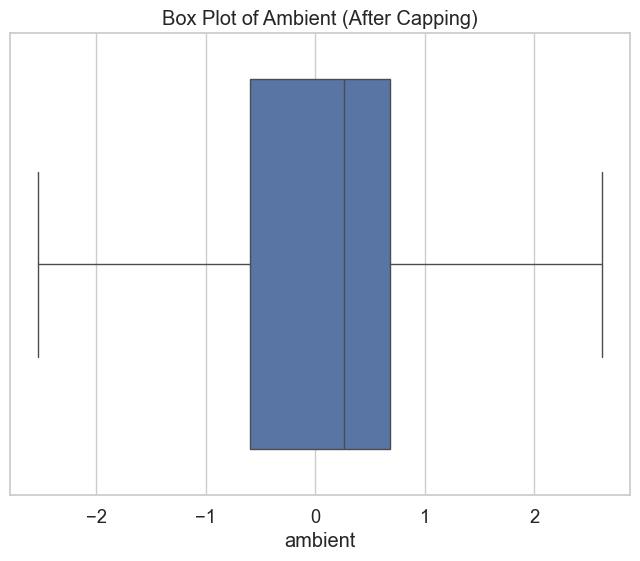

In [58]:
# Create a box plot for the capped 'ambient' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df2['ambient'])
plt.title('Box Plot of Ambient (After Capping)')
plt.show()

#### Capping Outliers from the u_d Column

In [59]:
# Calculate Q1, Q3, and IQR for the 'u_d' column
Q1_ud_cap = df2['u_d'].quantile(0.25)  # 25th percentile
Q3_ud_cap = df2['u_d'].quantile(0.75)  # 75th percentile

IQR_ud_cap = Q3_ud_cap - Q1_ud_cap  # Interquartile Range
IQR_ud_cap

1.18484969

In [60]:
# Define lower and upper bounds for 'u_d'
lower_bound_ud_cap = Q1_ud_cap - 1.5 * IQR_ud_cap
upper_bound_ud_cap = Q3_ud_cap + 1.5 * IQR_ud_cap

lower_bound_ud_cap,upper_bound_ud_cap

(-2.60363321, 2.13576555)

In [61]:
# Cap outliers in the 'u_d' column (replace existing column)

df2['u_d'] = df2['u_d'].clip(lower=lower_bound_ud_cap, upper=upper_bound_ud_cap)


#### Capping Outliers from the torque Column

In [62]:
# Calculate Q1, Q3, and IQR for the 'torque' column
Q1_torque_cap = df2['torque'].quantile(0.25)  # 25th percentile
Q3_torque_cap = df2['torque'].quantile(0.75)  # 75th percentile

IQR_torque_cap = Q3_torque_cap - Q1_torque_cap  # Interquartile Range
IQR_torque_cap

0.8140878475

In [63]:
# Define lower and upper bounds for 'torque'

lower_bound_torque_cap = Q1_torque_cap - 1.5 * IQR_torque_cap
upper_bound_torque_cap = Q3_torque_cap + 1.5 * IQR_torque_cap
lower_bound_torque_cap,upper_bound_torque_cap

(-1.48804908125, 1.76830230875)

In [64]:
# Cap outliers in the 'torque' column (replace existing column)

df2['torque'] = df2['torque'].clip(lower=lower_bound_torque_cap, upper=upper_bound_torque_cap)

#### Capping Outliers from the i_q Column

In [65]:
# Calculate Q1, Q3, and IQR for the 'i_q' column

Q1_iq_cap = df2['i_q'].quantile(0.25)  # 25th percentile
Q3_iq_cap = df2['i_q'].quantile(0.75)  # 75th percentile

IQR_iq_cap = Q3_iq_cap - Q1_iq_cap  # Interquartile Range
IQR_iq_cap

0.756528935

In [66]:
# Define lower and upper bounds for 'i_q'
lower_bound_iq_cap = Q1_iq_cap - 1.5 * IQR_iq_cap
upper_bound_iq_cap = Q3_iq_cap + 1.5 * IQR_iq_cap

lower_bound_iq_cap,upper_bound_iq_cap

(-1.3920623324999999, 1.6340534075)

In [67]:
# Cap outliers in the 'i_q' column (replace existing column)
df2['i_q'] = df2['i_q'].clip(lower=lower_bound_iq_cap, upper=upper_bound_iq_cap)


#### Capping Outliers from the pm Column

In [68]:
# Calculate Q1, Q3, and IQR for the 'pm' column

Q1_pm_cap = df2['pm'].quantile(0.25)  # 25th percentile
Q3_pm_cap = df2['pm'].quantile(0.75)  # 75th percentile

IQR_pm_cap = Q3_pm_cap - Q1_pm_cap  # Interquartile Range
IQR_pm_cap

1.352998955

In [69]:
# Define lower and upper bounds for 'pm'

lower_bound_pm_cap = Q1_pm_cap - 1.5 * IQR_pm_cap
upper_bound_pm_cap = Q3_pm_cap + 1.5 * IQR_pm_cap

lower_bound_pm_cap, upper_bound_pm_cap

(-2.7018059799999996, 2.7101898399999995)

In [70]:
# Cap outliers in the 'pm' column (replace existing column)
df2['pm'] = df2['pm'].clip(lower=lower_bound_pm_cap, upper=upper_bound_pm_cap)


#### Lets visualize the Capped columns using boxplots

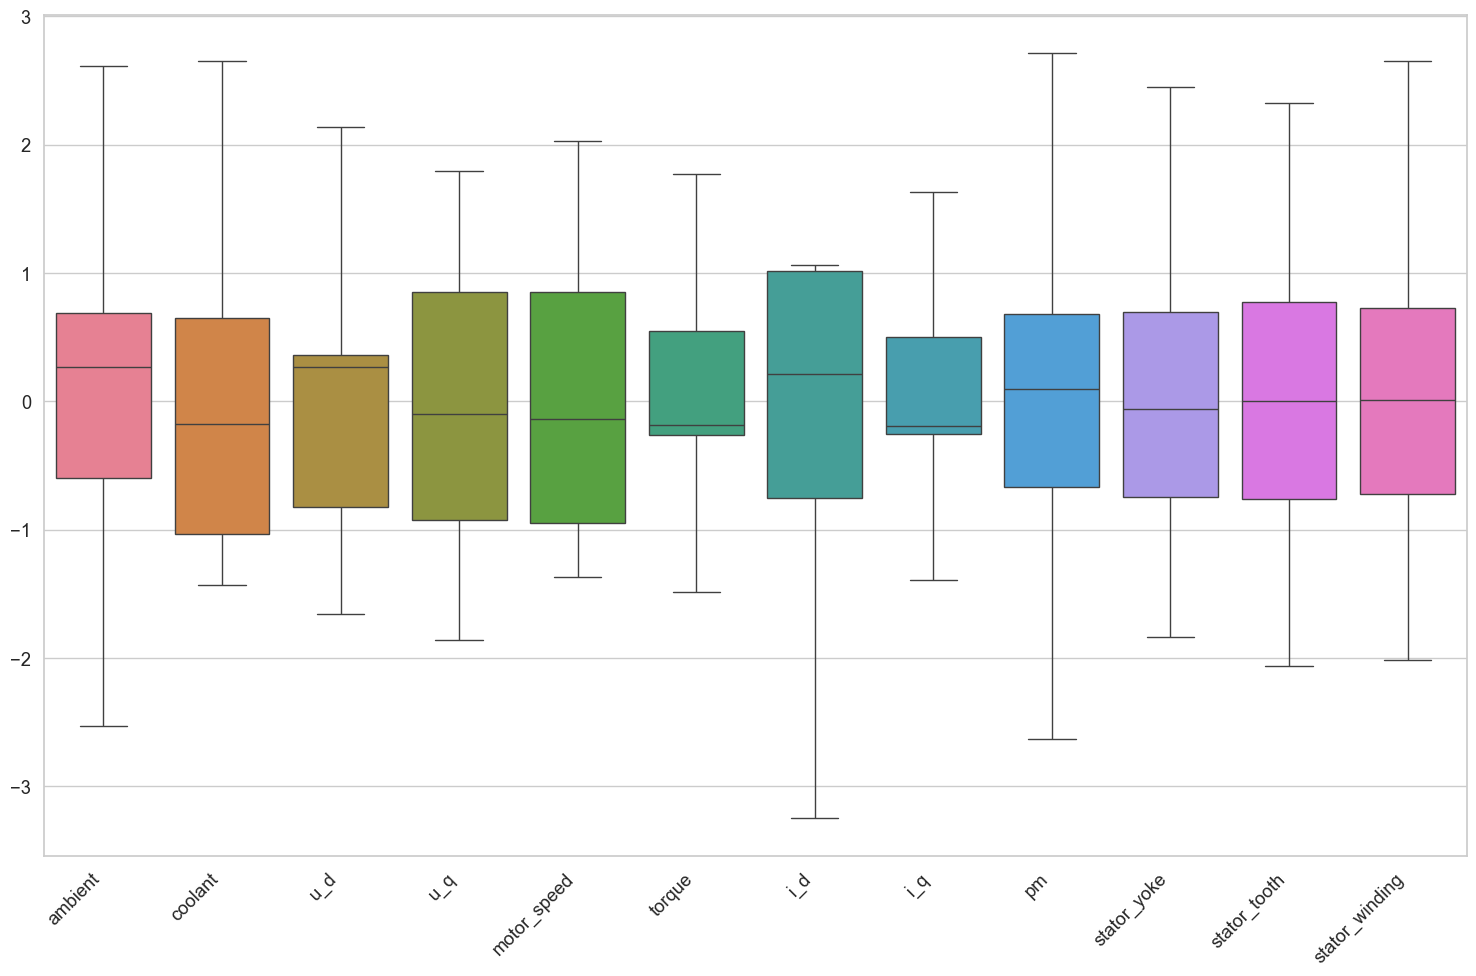

In [71]:
# Boxplots
sns.set(style="whitegrid", font_scale=1.2)  # Increase font scale and use a clean style

# Create a box plot for all l columns
plt.figure(figsize=(15, 10))  # Adjust figure size
sns.boxplot(data=df2)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


### Correlation matrix

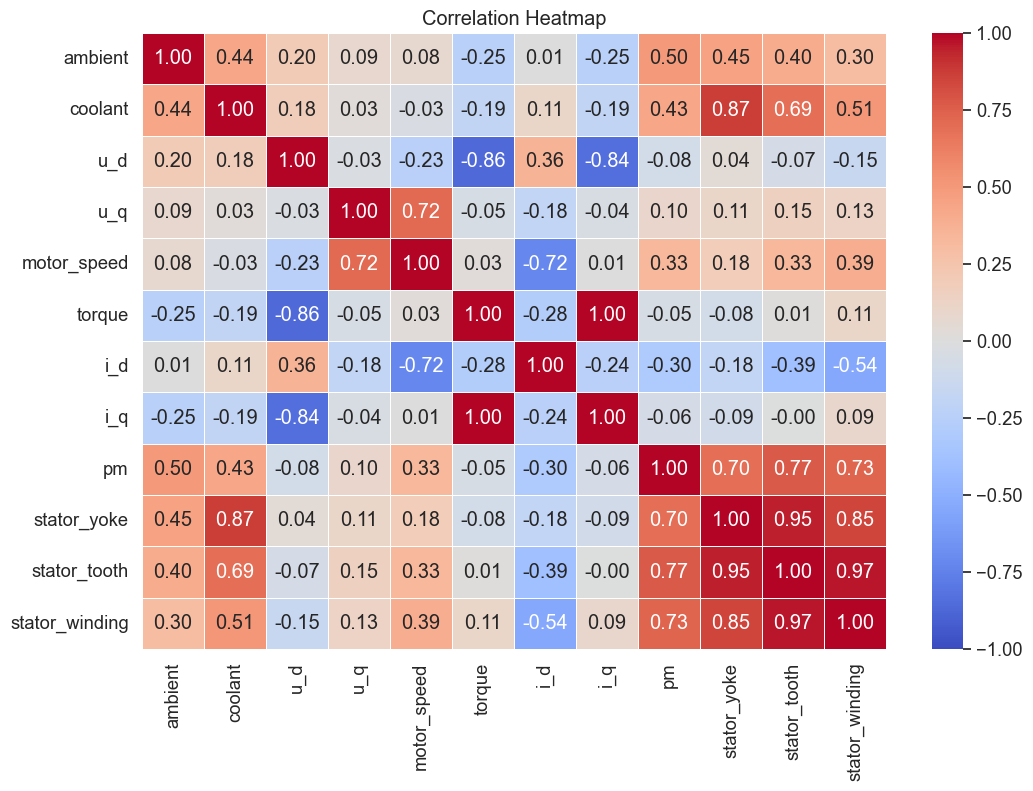

In [72]:
# Compute the correlation matrix
corr_matrix = df2.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Add title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

In [73]:
df2.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


### Variance Inflation Factor (VIF) To check Multicollinearity

#### What Happens if You Don’t Include a Constant?
If you exclude the constant, the regression model used for VIF calculation will force the intercept to be zero. This can lead to:

1.Incorrect VIF values.

2.Misinterpretation of multicollinearity.

3.Poor model performance.



In [74]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for a dataset
def calculate_vif(dataframe):
    # Exclude the target column ('motor_speed')
    independent_vars = dataframe.drop(columns=['motor_speed'])
    
    # Add a constant column for the intercept
    independent_vars['const'] = 1
    
    # Calculate VIF for each independent variable
    vif = pd.DataFrame()
    vif['Feature'] = independent_vars.columns
    vif['VIF'] = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]
    
    return vif

# Assuming df, df1, and df2 are your datasets
# df: Original dataset
# df1: Dataset with outliers trimmed
# df2: Dataset with outliers capped

# Calculate VIF for each dataset
vif_df = calculate_vif(df)  # VIF for original dataset
vif_df1 = calculate_vif(df1)  # VIF for trimmed dataset
vif_df2 = calculate_vif(df2)  # VIF for capped dataset

# Rename VIF columns for clarity
vif_df = vif_df.rename(columns={'VIF': 'VIF_Original'})
vif_df1 = vif_df1.rename(columns={'VIF': 'VIF_Trimmed'})
vif_df2 = vif_df2.rename(columns={'VIF': 'VIF_Capped'})

# Combine the results into a single DataFrame for comparison
vif_comparison = vif_df.merge(vif_df1, on='Feature').merge(vif_df2, on='Feature')

vif_comparison

,Feature,VIF_Original,VIF_Trimmed,VIF_Capped
0,ambient,1.591301,1.378488,1.581127
1,coolant,39.200092,43.481246,39.819893
2,u_d,4.663596,8.942599,5.327801
3,u_q,1.494069,1.799626,1.488260
4,torque,260.458613,217.883552,185.507166
5,i_d,2.975567,4.053073,3.028502
6,i_q,230.363548,165.673196,163.048281
7,pm,4.233975,3.931737,4.227846
8,stator_yoke,369.137061,411.061586,377.505445
9,stator_tooth,642.335550,758.104351,654.535899


### Stator

What is Stator Winding?
The stator winding refers to the coils of wire wound around the stator (the stationary part of an electric motor).

When electric current flows through these windings, they generate a magnetic field, which interacts with the rotor (the rotating part) to produce motion (torque).

The temperature of the stator winding is measured because excessive heat can damage the insulation around the wires, leading to motor failure.

Stator contain all the Winding used to create rotating mangnetic feild when the lectricity is passed through the wires to power the coils we find an electric terminal box on the top

#### (pm) Permanent Magnet surface temperature representing the rotor temperature. 
#### This was measured with an infrared thermography unit.

In [75]:
%%html
<div style="display: flex; align-items: center; margin-bottom: 20px;">
    <!-- Left Image (infrared-themography.jpg) -->
    <img src="device.jpg" alt="Infrared Thermography" style="width: 500px; height: 350px; margin-right: 20px;">
    
    <!-- Right Image (device.jpg) -->
    <img src="infrared-themography.jpg" alt="Device" style="width: 500px; height: 350px;">
</div>

<!-- Text Below the Images -->
<div style="font-size: 16px; font-family: Arial, sans-serif; font-style: italic; color: #333; text-align: center;">
    <p>Infrared thermography is equipment or method, which detects infrared energy emitted from object, converts it to temperature, and displays image of temperature distribution.</p>
</div>

In [76]:
df2.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


### Feature Engineering

In [77]:
# 1. Total Current
df2['total_current'] = np.sqrt(df2['i_d']**2 + df2['i_q']**2)

# 2. Total Voltage
df2['total_voltage'] = np.sqrt(df2['u_d']**2 + df2['u_q']**2)

# 3. Electrical Power (Active Power)
df2['electrical_power'] = df2['u_d'] * df2['i_d'] + df2['u_q'] * df2['i_q']

# 4. Reactive Power
#df2['reactive_power'] = df2['u_q'] * df2['i_d'] - df2['u_d'] * df2['i_q']

# 5. Apparent Power
#df2['apparent_power'] = np.sqrt(df2['electrical_power']**2 + df2['reactive_power']**2)

# 6. Power Factor
#df2['power_factor'] = df2['electrical_power'] / df2['apparent_power']

# 7. Current Angle
#df2['current_angle'] = np.arctan2(df2['i_q'], df2['i_d'])

# 8. Voltage Angle
#df2['voltage_angle'] = np.arctan2(df2['u_q'], df2['u_d'])

# 9. Electrical Torque (Simplified)
#df2['electrical_torque'] = df2['i_q']

# 10. Efficiency
#df2['efficiency'] = (df2['torque'] * df2['motor_speed']) / df2['electrical_power']

In [78]:
df2.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,total_current,total_voltage,electrical_power
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,1.058521,1.338647,0.656724
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,1.058453,1.338906,0.658406
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,1.058390,1.343680,0.662582
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,1.061958,1.343940,0.666159
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,1.060869,1.345541,0.667230


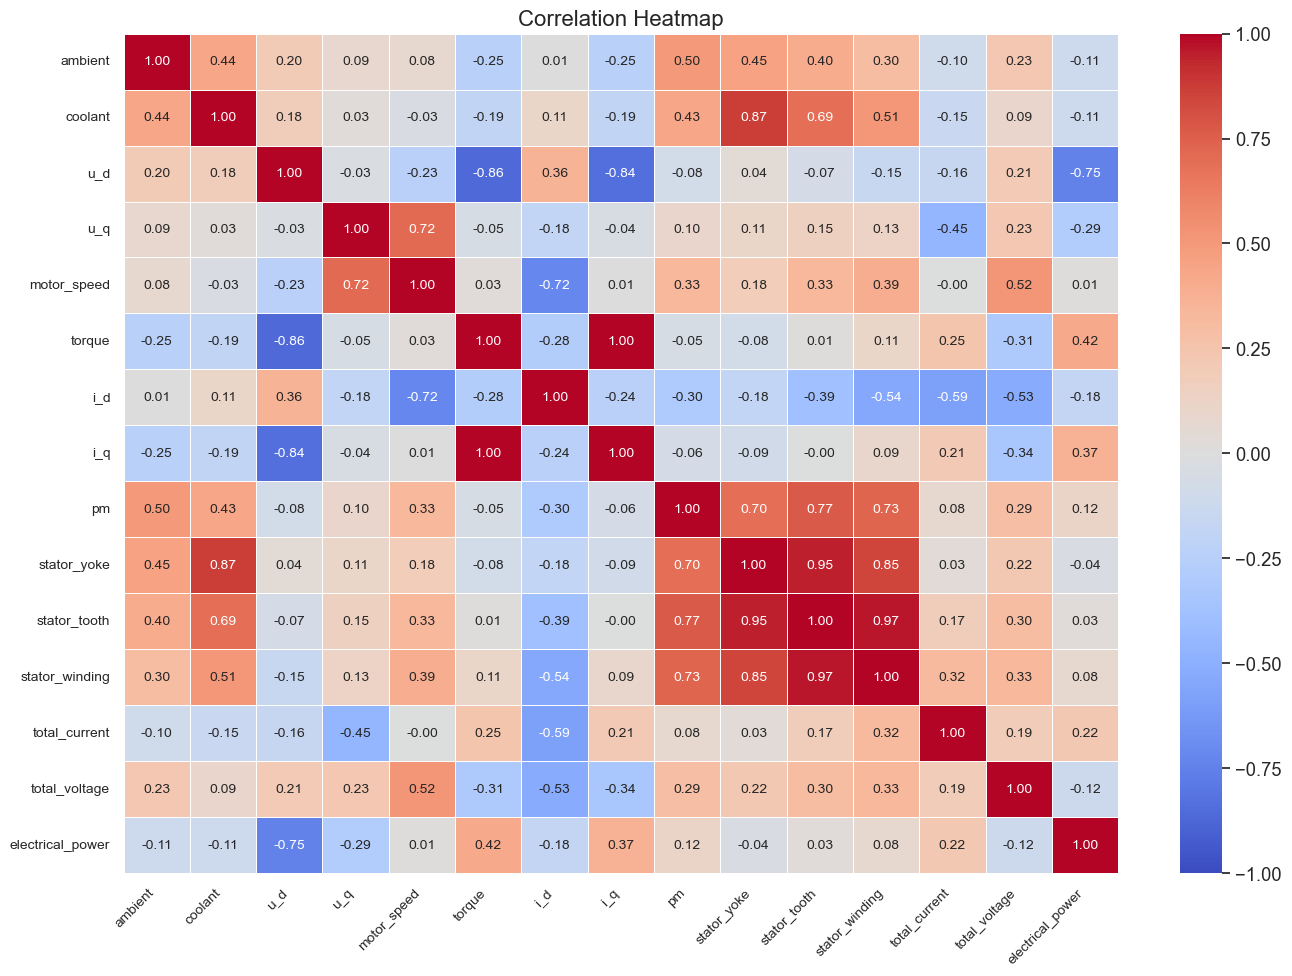

In [79]:
corr_matrix = df2.corr()

# Plot the heatmap with improved readability
plt.figure(figsize=(14, 10))  # Increase figure size
sns.heatmap(
    corr_matrix,
    annot=True,  # Show correlation values
    fmt=".2f",   # Format values to 2 decimal places
    cmap="coolwarm",  # Use a diverging color map
    vmin=-1, vmax=1,  # Set color scale range
    linewidths=0.5,   # Add thin lines between cells
    annot_kws={"size": 10}  # Adjust annotation font size
)

# Add title and labels
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels and adjust font size
plt.yticks(rotation=0, fontsize=10)  # Keep y-axis labels horizontal and adjust font size
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [80]:
from sklearn.feature_selection import SelectKBest, f_regression

# Define features and target
X = df2.drop(columns=['motor_speed'])
y = df2['motor_speed']

# Select top k features using ANOVA F-test
selector = SelectKBest(score_func=f_regression, k=5)  # Select top 5 features
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['u_q', 'i_d', 'stator_tooth', 'stator_winding', 'total_voltage'], dtype='object')
